In [4]:
#We load in all necessary libraries.

import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import pandas as pd
from tqdm import tqdm
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tabulate import tabulate
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scikit_posthocs as sp

In [5]:
#We read in our main file.
df = pd.read_csv("Newspapers_Complete.csv")

In [6]:
#We inspect it.
df.head()

,Author,Background,Character count,Culture,Day of the week,Domestic,Foreign,Frontpage,Half-life,Highlighted,...,Section trees,Shelf-life,Slope after peak,Slope before peak,Sport,Time of the day,Timestamp date,Total views,Views,Views in 1st 2h
0,unknown,False,3286.0,False,Wednesday,False,False,True,28,False,...,"['ge/extra/opinie-column', 'ge']",38,0.0,0.176591,False,19,2021-05-26 19:00:00,3,0,0
1,unknown,False,3286.0,False,Wednesday,False,False,True,28,False,...,"['ge/extra/opinie-column', 'ge']",38,0.0,0.176591,False,20,2021-05-26 20:00:00,3,0,0
2,unknown,False,3286.0,False,Wednesday,False,False,True,28,False,...,"['ge/extra/opinie-column', 'ge']",38,0.0,0.176591,False,21,2021-05-26 21:00:00,3,0,0
3,unknown,False,3286.0,False,Wednesday,False,False,True,28,False,...,"['ge/extra/opinie-column', 'ge']",38,0.0,0.176591,False,22,2021-05-26 22:00:00,3,0,0
4,unknown,False,3286.0,False,Wednesday,False,False,True,28,False,...,"['ge/extra/opinie-column', 'ge']",38,0.0,0.176591,False,23,2021-05-26 23:00:00,3,0,0


In [7]:
#We inspect our columns.
df.columns

Index(['Author', 'Background', 'Character count', 'Culture', 'Day of the week',
       'Domestic', 'Foreign', 'Frontpage', 'Half-life', 'Highlighted',
       'Hours passed', 'Hours till peak', 'Inline media', 'Landing page',
       'Lifestyle', 'Newspaper', 'Number of sections (excl. frontpage)',
       'Number of sections (incl. frontpage)', 'Opinion', 'Paid content',
       'Popularity', 'Popularity rank', 'Popularity rank in 1st 2h',
       'Publication date', 'Recommended', 'Regional', 'Section trees',
       'Shelf-life', 'Slope after peak', 'Slope before peak', 'Sport',
       'Time of the day', 'Timestamp date', 'Total views', 'Views',
       'Views in 1st 2h'],
      dtype='object')

In [8]:
#We first create a non-lagged version in which we only keep the publication ids and the section dummies.
df_1 = df[["Background", "Culture", "Domestic", "Foreign", "Frontpage", "Highlighted", "Recommended", 
           "Landing page", "Lifestyle", "Newspaper", "Opinion", "Regional", "Sport"]].groupby(["Newspaper", "Landing page"]).nth(0).reset_index()

In [9]:
#We inspect it.
df_1.head()

,Newspaper,Landing page,Background,Culture,Domestic,Foreign,Frontpage,Highlighted,Recommended,Lifestyle,Opinion,Regional,Sport
0,Gooieneemlander,/cnt/dmf20190705_81476516,False,False,False,False,True,False,False,False,True,False,False
1,Gooieneemlander,/cnt/dmf20200501_53506347,True,False,False,False,False,False,False,False,False,False,False
2,Gooieneemlander,/cnt/dmf20201026_62507126,False,False,False,True,False,False,False,False,False,False,False
3,Gooieneemlander,/cnt/dmf20201113_84348583,False,False,False,False,False,True,False,False,False,True,False
4,Gooieneemlander,/cnt/dmf20201228_15837729,False,False,True,False,False,False,False,False,False,False,False


In [10]:
#We than first make the FALSE value missing, thus only keeping TRUE values.
#We than melt the data so that each section-publication combination has its own row.
df_long = pd.melt(df_1.replace(False, np.nan), id_vars=["Newspaper", "Landing page"], var_name="Section", value_name="Presence").dropna()

In [11]:
#We inspect the data.
df_long.head()

,Newspaper,Landing page,Section,Presence
1,Gooieneemlander,/cnt/dmf20200501_53506347,Background,True
57,Gooieneemlander,/cnt/dmf20210412_44898843,Background,True
99,Gooieneemlander,/cnt/dmf20210412_88478976,Background,True
143,Gooieneemlander,/cnt/dmf20210413_43179854,Background,True
207,Gooieneemlander,/cnt/dmf20210414_24292232,Background,True


In [12]:
#We than create another non-lagged file, in which we get our dependent variables total views and shelf-life.
df_2 = df[["Total views", "Shelf-life", "Landing page", "Newspaper"]].groupby(["Newspaper", "Landing page"]).nth(0).reset_index()

In [13]:
#We inspect the data.
df_2.head()

,Newspaper,Landing page,Total views,Shelf-life
0,Gooieneemlander,/cnt/dmf20190705_81476516,3,38
1,Gooieneemlander,/cnt/dmf20200501_53506347,13,19
2,Gooieneemlander,/cnt/dmf20201026_62507126,2,5
3,Gooieneemlander,/cnt/dmf20201113_84348583,8,28
4,Gooieneemlander,/cnt/dmf20201228_15837729,1,2


In [14]:
#We then merge it with our long-format publication-section file.
df_long2 = df_long.merge(df_2,  how="left", on=["Newspaper", "Landing page"]).sort_values("Section")

In [15]:
#We replace the spaces in our columns with an underscore.
df_long2.columns = [c.replace(" ", "_").replace("-", "_") for c in df_long2.columns]

In [16]:
#We inspect the data.
df_long2.head()

,Newspaper,Landing_page,Section,Presence,Total_views,Shelf_life
0,Gooieneemlander,/cnt/dmf20200501_53506347,Background,True,13,19
696,Leidschdagblad,/cnt/dmf20210511_72491699,Background,True,7,22
697,Leidschdagblad,/cnt/dmf20210511_7962344,Background,True,2,20
698,Leidschdagblad,/cnt/dmf20210511_83218352,Background,True,4,1135
699,Leidschdagblad,/cnt/dmf20210511_89801318,Background,True,5,14


## RQ2A: Popularity of Sections

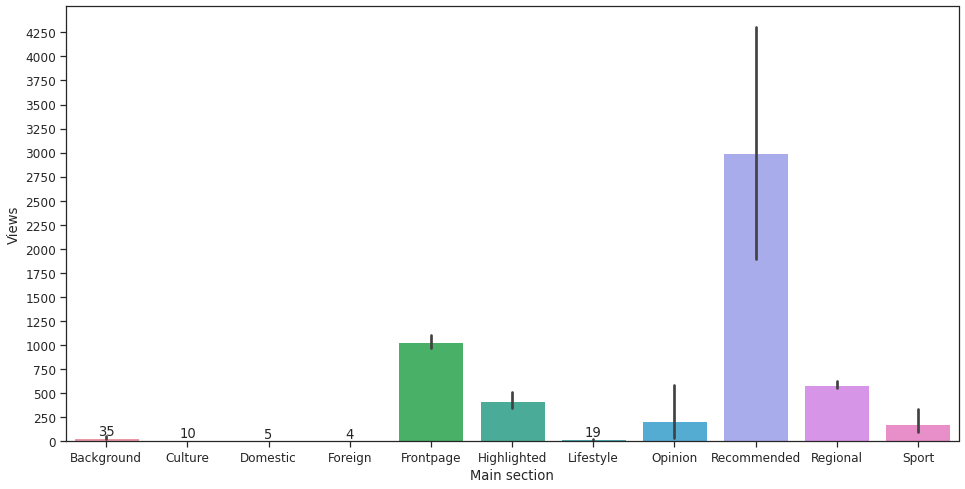

In [18]:
#We create a barplot highlihting the average total amount of views gathered per section.
fig, ax = plt.subplots(figsize=(16,8))

sns.set(style="ticks", font_scale=1.1, palette="bright")

sns.barplot(x="Section", y="Total_views", data=df_long2, ax=ax)

ax.set_xlabel("Main section")
ax.set_ylabel("Views")

ax.set_yticks(np.arange(0,4500,250))

threshold = 150
for c in ax.containers:
    labels = [int(v) if v < threshold else "" for v in c.datavalues]    
    ax.bar_label(c, labels=labels)

plt.savefig("Section x Total views V2.pdf", format="pdf", bbox_inches="tight")

In [25]:
#We inspect the data per group.
df_long2.groupby("Section")["Total_views"].describe()

,count,mean,std,min,25%,50%,75%,max
Section,,,,,,,,
Background,1055.0,35.940284,202.716792,1.0,2.00,5.0,13.00,5011.0
Culture,427.0,10.391101,21.247904,1.0,2.00,4.0,8.00,202.0
Domestic,12346.0,5.217479,24.897950,1.0,1.00,2.0,3.00,929.0
Foreign,6402.0,4.576539,56.304436,1.0,1.00,1.0,3.00,4383.0
Frontpage,11950.0,1027.986025,3916.635448,1.0,39.00,179.0,743.75,220184.0
Highlighted,1573.0,423.889383,1653.824156,1.0,13.00,53.0,245.00,36983.0
Lifestyle,909.0,19.550055,89.096523,1.0,2.00,5.0,11.00,2052.0
Opinion,1281.0,214.367681,6160.309362,1.0,2.00,5.0,15.00,220184.0
Recommended,258.0,2998.833333,10106.665410,1.0,65.75,317.0,1598.75,122780.0


In [26]:
#See script III (results) for the full explanation of the function.
def report_anova(data, x, y):
    lists = pd.pivot(data, columns=x, values=y).values.T.tolist()
    lists = [[i for i in l if pd.notna(i)] for l in lists]
    F, p = stats.levene(*lists)
    print("Levene's Test")
    print(tabulate([[F, p]], ["F", "p"], "simple"))

    print("\n")

    mod = ols(f"{y} ~ {x}", data=data).fit()

    aov_table = sm.stats.anova_lm(mod, typ=2)
    esq_sm = aov_table["sum_sq"][0]/(aov_table["sum_sq"][0]+aov_table["sum_sq"][1])
    aov_table["EtaSq"] = [esq_sm, "NaN"]
    print("One-way ANOVA")
    print(tabulate(aov_table, headers="keys"))

    print("\n")
    
    H, p = stats.kruskal(*lists)
    print("Kruskal-Wallis test")
    print(tabulate([[H, p]], ["H", "p"], "simple"))

    print("\n")

    pair_t = mod.t_test_pairwise(x)
    print("Pairwise T-Test")
    print(tabulate(pair_t.result_frame, headers="keys"))
    
    print("\n")
    print("Dunn’s test")
    dunn = sp.posthoc_dunn(data, val_col=y, group_col=x)
    print(tabulate(dunn, headers="keys"))

In [27]:
#We perform a ANOVA to see if the sections significantly differ in total view amount.
report_anova(df_long2, "Section", "Total_views")

Levene's Test
      F             p
-------  ------------
130.174  1.42936e-270


One-way ANOVA
               sum_sq     df        F          PR(>F)        EtaSq
--------  -----------  -----  -------  --------------  -----------
Section   1.05238e+10     10  141.502    1.71988e-294    0.0227551
Residual  4.51959e+11  60770  nan      nan             nan


Kruskal-Wallis test
    H    p
-----  ---
34852    0


Pairwise T-Test
                                 coef    std err            t         P>|t|    Conf. Int. Low    Conf. Int. Upp.    pvalue-hs  reject-hs
-----------------------  ------------  ---------  -----------  ------------  ----------------  -----------------  -----------  -----------
Culture-Background         -25.5492     156.419    -0.163338   0.870253             -332.131           281.032    1            False
Domestic-Background        -30.7228      87.4751   -0.351218   0.725426             -202.174           140.729    0.999998     False
Foreign-Background         -3

## RQ2B: Popularity of Sections

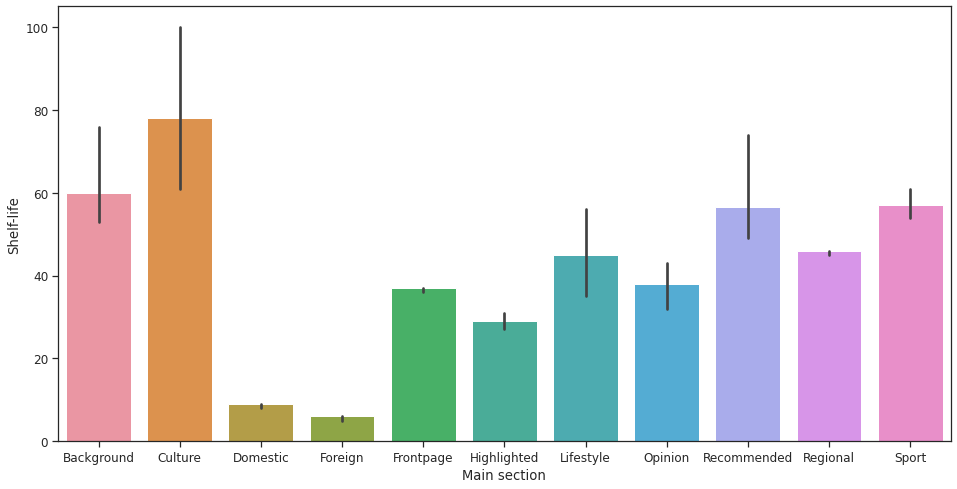

In [28]:
#We compare the popularity (thus shelf-life) of sections.
#We do so by their median value.
fig, ax = plt.subplots(figsize=(16,8))

sns.set(style="ticks", font_scale=1.1, palette="bright")

sns.barplot(x="Section", y="Shelf_life", data=df_long2, ax=ax, estimator=np.median)

ax.set_xlabel("Main section")
ax.set_ylabel("Shelf-life")

plt.savefig("Section x Shelf-life V2.pdf", format="pdf", bbox_inches="tight")

In [29]:
#We inspect it as well per group.
df_long2.groupby("Section")["Shelf_life"].describe()

,count,mean,std,min,25%,50%,75%,max
Section,,,,,,,,
Background,1055.0,269.454028,410.683253,1.0,15.5,60.0,373.5,2067.0
Culture,427.0,231.060890,341.654853,1.0,9.0,78.0,296.5,1732.0
Domestic,12346.0,148.141584,322.118252,1.0,2.0,9.0,111.0,2112.0
Foreign,6402.0,145.199469,325.530247,1.0,1.0,6.0,91.0,2091.0
Frontpage,11950.0,102.787699,218.724448,1.0,24.0,37.0,69.0,2024.0
Highlighted,1573.0,111.631914,243.582400,1.0,17.0,29.0,77.0,1871.0
Lifestyle,909.0,241.562156,395.294043,1.0,11.0,45.0,332.0,2049.0
Opinion,1281.0,161.423107,326.731463,1.0,12.0,38.0,113.0,2072.0
Recommended,258.0,162.267442,230.463300,1.0,31.0,56.5,205.0,1280.0


In [30]:
#We also perform on ANOVA on shelf-life per section.
report_anova(df_long2, "Section", "Shelf_life")

Levene's Test
      F             p
-------  ------------
81.3813  3.12381e-167


One-way ANOVA
               sum_sq     df         F          PR(>F)        EtaSq
--------  -----------  -----  --------  --------------  -----------
Section   7.13294e+07     10   77.6814    2.21516e-159    0.0126215
Residual  5.58008e+09  60770  nan       nan             nan


Kruskal-Wallis test
      H    p
-------  ---
5879.63    0


Pairwise T-Test
                                coef    std err            t        P>|t|    Conf. Int. Low    Conf. Int. Upp.    pvalue-hs  reject-hs
-----------------------  -----------  ---------  -----------  -----------  ----------------  -----------------  -----------  -----------
Culture-Background        -38.3931     17.3804    -2.20899    0.027179            -72.4588            -4.32751  0.301079     False
Domestic-Background      -121.312       9.71975  -12.481      1.04816e-35        -140.363           -102.262    0            True
Foreign-Background       -12